## Интеллектуальные системы и технологии  
Практика №3. SVM, Knn, Random Forest  
Жаров Всеволод, ИММО-01-23

In [57]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import classification_report
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree

### Функции

In [39]:
def compare_quality(y_predict, y_test, need_print_data=False):
    if need_print_data:
        print(y_predict)
        print("-----")
        print(np.array(y_test))
        print("-----")
    print(classification_report(np.array(y_test), y_predict))
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(np.array(y_test), y_predict, ax=ax, colorbar=False)
    plt.show()

In [34]:
# Функции для построения tsne и umap и быстрой их отрисовки
def some_tsne(data_sc, answers, perplex):
    T = TSNE(n_components=2, perplexity=perplex, random_state=567)
    TSNE_features = pd.DataFrame(data=T.fit_transform(data_sc), columns=["x", "y"])
    TSNE_features["keys"] = answers

    fig = plt.figure()
    sns.scatterplot(data=TSNE_features, x="x", y="y", hue="keys").set_title(f"TSNE {perplex}")
    return fig

def make_tsne(data_sc, answers, perplexities = [15, 25, 35]):
    figures = []
    for p in perplexities:
        figures.append(some_tsne(data_sc, answers, p))
    return figures

def make_umap(data_sc, answers, n_n = (5, 25, 50), m_d = (0.1, 0.6)):
    um = dict()
    for i in range(len(n_n)):
        for j in range(len(m_d)):
            um[(n_n[i], m_d[j])] = (umap.UMAP(n_neighbors=n_n[i], min_dist=m_d[j], random_state=567).fit_transform(data_sc))
            um[(n_n[i], m_d[j])] = pd.DataFrame(um[(n_n[i], m_d[j])], columns = ["x", "y"])
            um[(n_n[i], m_d[j])]["keys"] = answers
    return um

def plot_umap(um, n_n, m_d):
    figures = []
    for i in n_n:
        for j in m_d:
            fig = plt.figure()
            figures.append(sns.scatterplot(data=um[(i, j)], x="x", y="y", hue="keys").set_title(f"UMAP n_n={i}, m_d={j}"))
    return figures

### Данные

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
ionosphere = fetch_ucirepo(id=52) 
  
# data (as pandas dataframes) 
X = ionosphere.data.features 
y = ionosphere.data.targets

In [3]:
X.tail()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute25,Attribute26,Attribute27,Attribute28,Attribute29,Attribute30,Attribute31,Attribute32,Attribute33,Attribute34
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243
350,1,0,0.84710,0.13533,0.73638,-0.06151,0.87873,0.08260,0.88928,-0.09139,...,0.86467,-0.15114,0.81147,-0.04822,0.78207,-0.00703,0.75747,-0.06678,0.85764,-0.06151


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print(f"Размер обучающей выборки - {x_train.shape}, {y_train.shape}")
print(f"Размер тестовой выборки - {x_test.shape}, {y_test.shape}")

Размер обучающей выборки - (280, 34), (280, 1)
Размер тестовой выборки - (71, 34), (71, 1)


### SMV

#### Перебор параметров и выбор лучшей модели

In [19]:
param_kernel = ["linear", "rbf", "poly", "sigmoid"]
c_list = [3, 5, 6, 8]
parameters = {"kernel" : param_kernel, "C" : c_list}
model = SVC()
grid_search_svm = GridSearchCV(estimator = model, param_grid = parameters)
grid_search_svm.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [3, 5, 6, 8],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [72]:
best_model = grid_search_svm.best_estimator_
print(best_model.kernel)
print(best_model.C)
print(len(best_model.support_vectors_))
svm_preds = best_model.predict(x_test)

rbf
5
80


              precision    recall  f1-score   support

           b       1.00      0.82      0.90        28
           g       0.90      1.00      0.95        43

    accuracy                           0.93        71
   macro avg       0.95      0.91      0.92        71
weighted avg       0.94      0.93      0.93        71



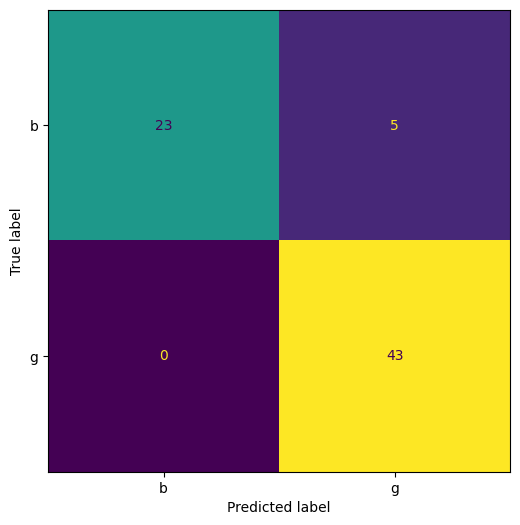

In [16]:
compare_quality(svm_preds, np.array(y_test))

In [77]:
best_model = grid_search_svm.best_estimator_
print(best_model.kernel)
print(best_model.C)
print(len(best_model.support_vectors_))
svm_preds = best_model.predict(x_train)

rbf
5
80


              precision    recall  f1-score   support

           b       0.99      0.95      0.97        98
           g       0.97      0.99      0.98       182

    accuracy                           0.98       280
   macro avg       0.98      0.97      0.98       280
weighted avg       0.98      0.98      0.98       280



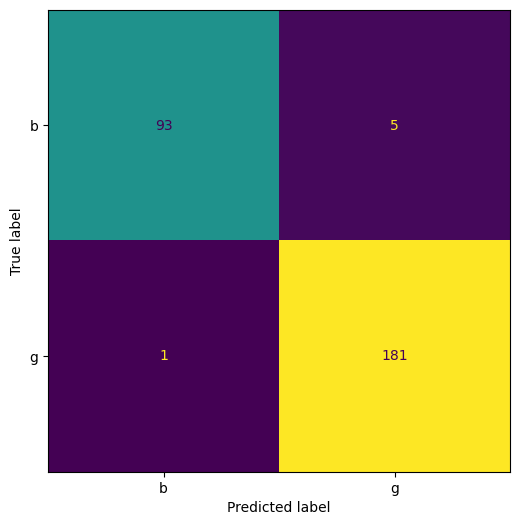

In [79]:
compare_quality(svm_preds, np.array(y_train))

In [27]:
svm_preds

array(['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'b', 'b', 'b',
       'b', 'g', 'g', 'g', 'b', 'g', 'b', 'g', 'b', 'b', 'g', 'g', 'b',
       'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'b', 'g', 'g', 'b',
       'g', 'g', 'g', 'g', 'b', 'g', 'b', 'b', 'g', 'g', 'g', 'g', 'b',
       'b', 'g', 'b', 'g', 'g', 'g', 'g', 'g', 'b', 'g', 'b', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'b'], dtype=object)

In [30]:
np.array(y_test.Class)

array(['g', 'g', 'g', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'b', 'b', 'b',
       'b', 'g', 'b', 'g', 'b', 'g', 'b', 'g', 'b', 'b', 'g', 'g', 'b',
       'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'b', 'g', 'g', 'b',
       'g', 'g', 'g', 'g', 'b', 'g', 'b', 'b', 'g', 'b', 'g', 'g', 'b',
       'b', 'g', 'b', 'g', 'g', 'g', 'g', 'b', 'b', 'b', 'b', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'b'], dtype=object)

#### TSNE

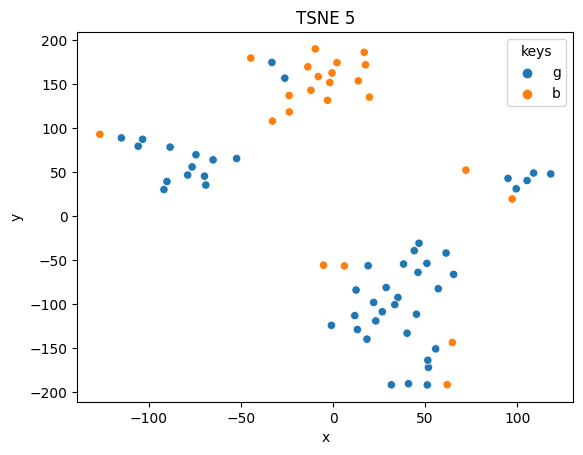

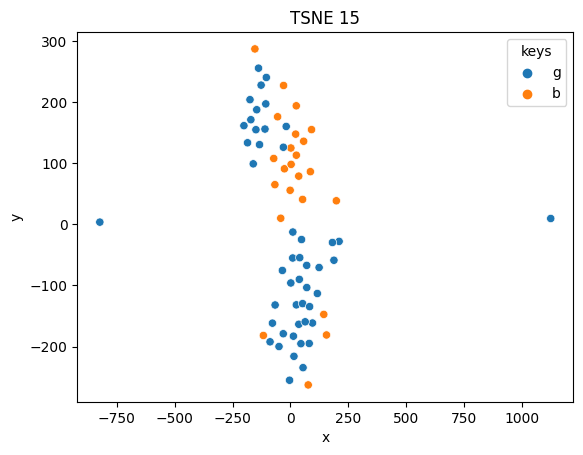

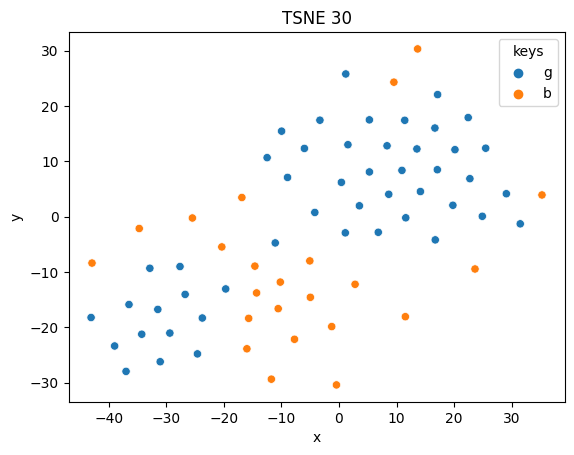

In [36]:
tsne_minmax_plots = make_tsne(x_test, svm_preds, perplexities=[5, 15, 30])

#### UMAP

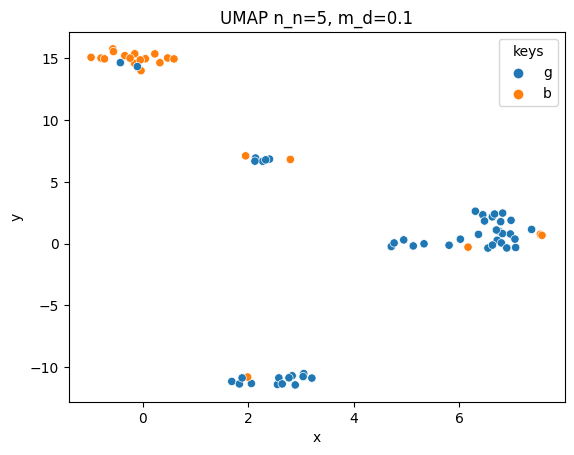

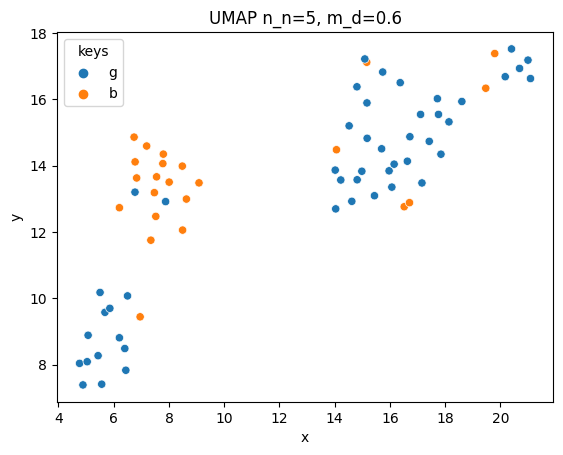

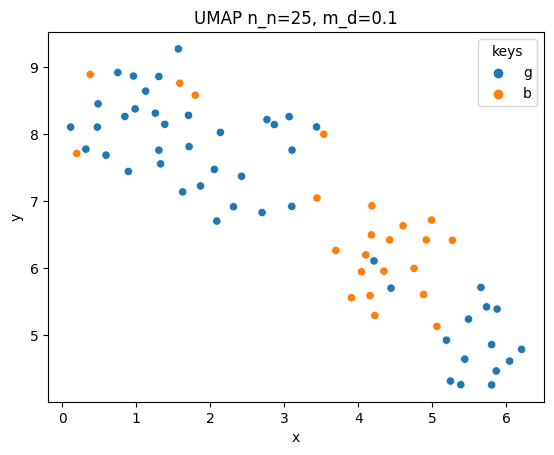

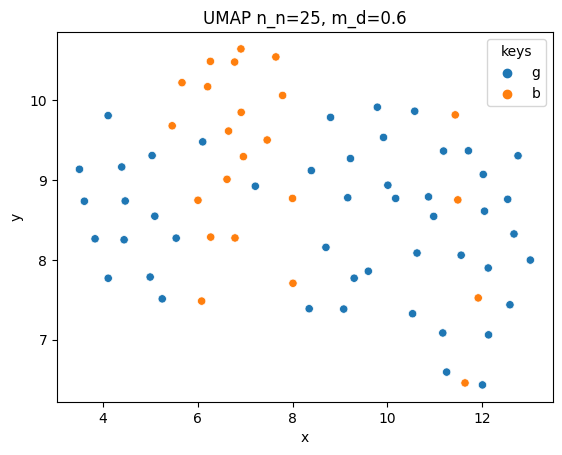

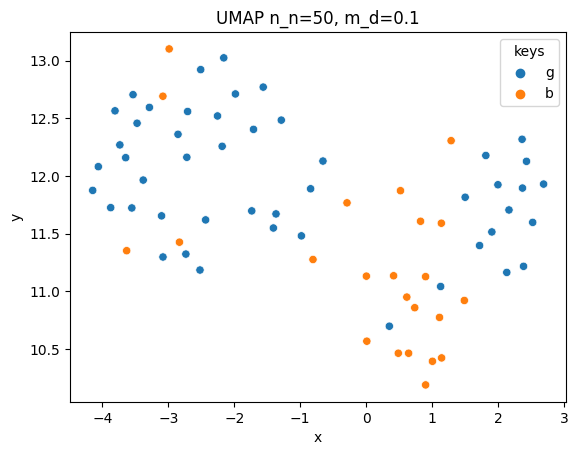

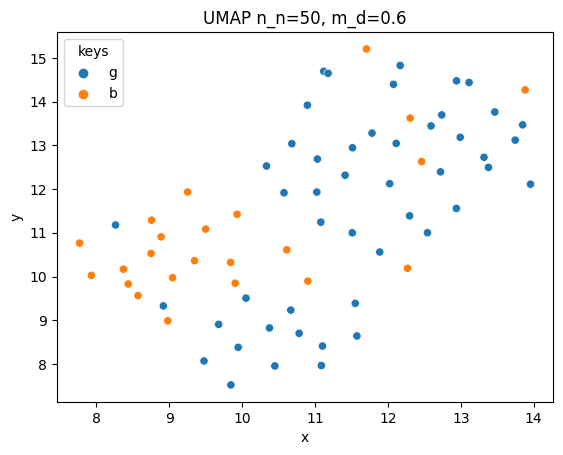

In [38]:
n_n = (5, 25, 50)
m_d = (0.1, 0.6)

um = make_umap(x_test, svm_preds, n_n, m_d)
umap_plots_minmax = plot_umap(um, n_n, m_d)

### Knn

#### Перебор параметров и выбор лучшей модели

In [51]:
number_of_neighbors = np.arange(2, 7)
algorithms = ["auto", "ball_tree", "kd_tree", "brute"]
weights_need = ["uniform", "distance"]
model_KNN = KNeighborsClassifier()
params = {"n_neighbors" : number_of_neighbors, "algorithm" : algorithms, "weights" : weights_need}
grid_search = GridSearchCV(estimator = model_KNN, param_grid = params)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([2, 3, 4, 5, 6]),
                         'weights': ['uniform', 'distance']})

In [52]:
print(grid_search.best_score_)
print(grid_search.best_params_)
knn_preds = grid_search.predict(x_test)

0.8857142857142858
{'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}


              precision    recall  f1-score   support

           b       1.00      0.75      0.86        28
           g       0.86      1.00      0.92        43

    accuracy                           0.90        71
   macro avg       0.93      0.88      0.89        71
weighted avg       0.92      0.90      0.90        71



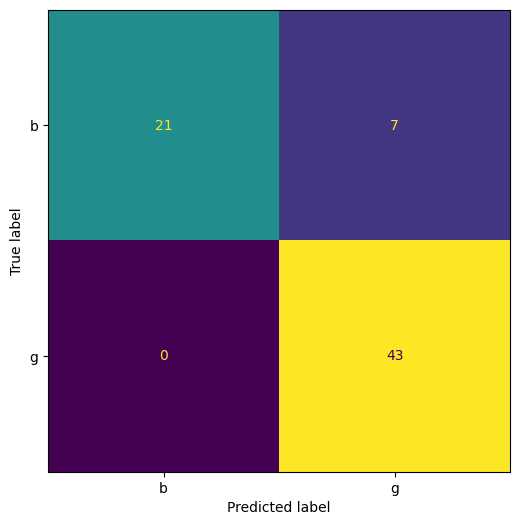

In [53]:
compare_quality(knn_preds, np.array(y_test))

In [80]:
print(grid_search.best_score_)
print(grid_search.best_params_)
knn_preds = grid_search.predict(x_train)

0.9464285714285715
{'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 50}


              precision    recall  f1-score   support

           b       1.00      1.00      1.00        98
           g       1.00      1.00      1.00       182

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



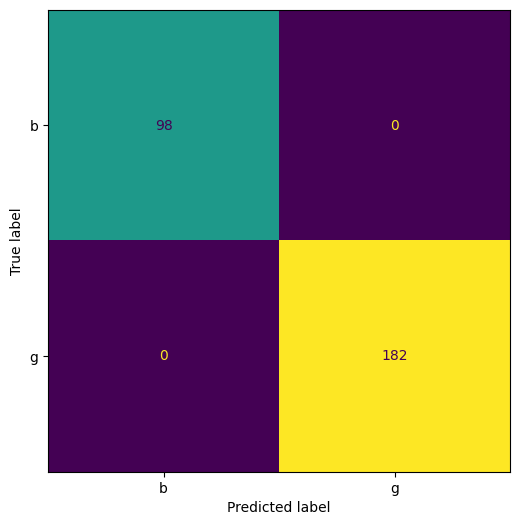

In [81]:
compare_quality(knn_preds, np.array(y_train))

#### TSNE

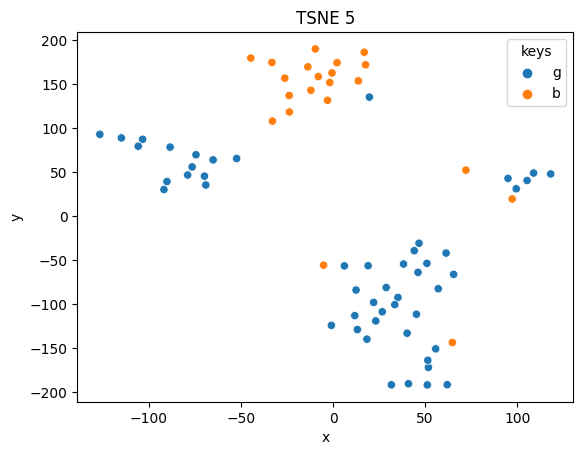

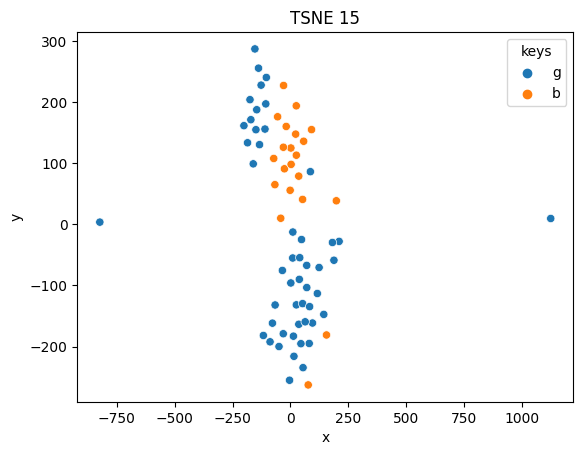

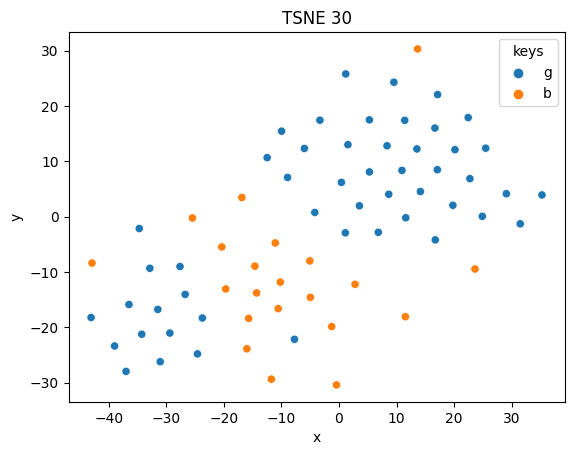

In [54]:
tsne_minmax_plots = make_tsne(x_test, knn_preds, perplexities=[5, 15, 30])

#### UMAP

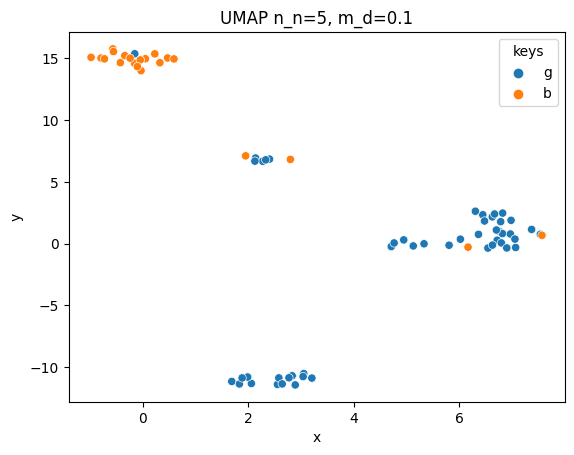

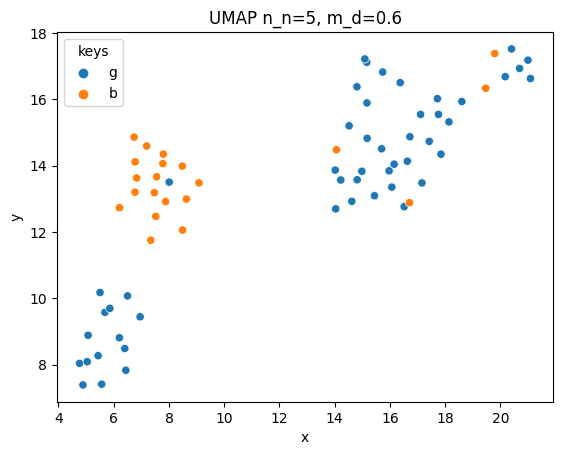

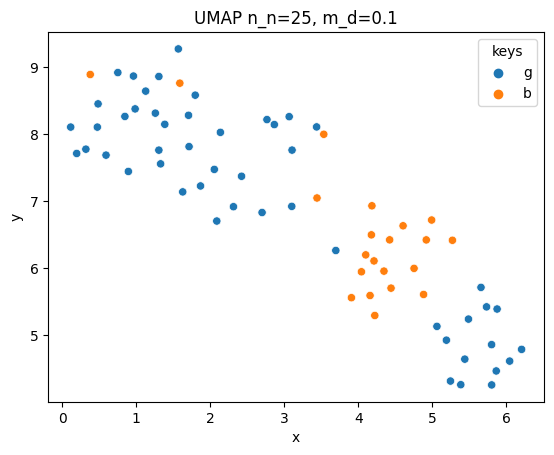

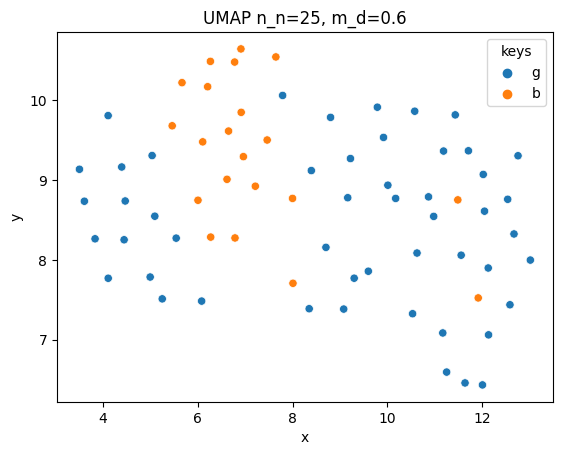

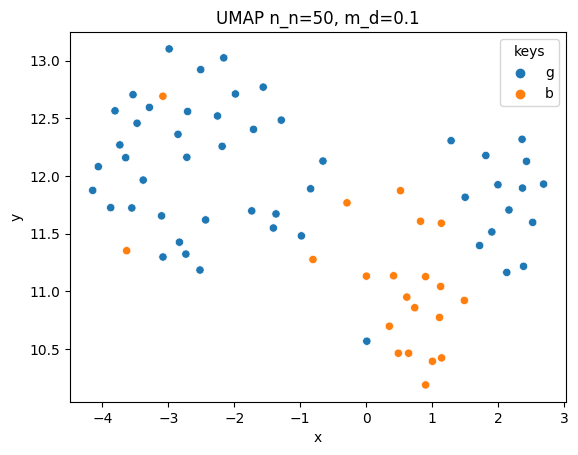

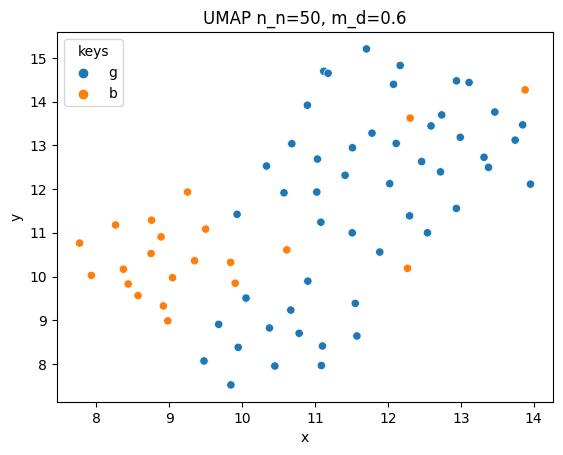

In [55]:
n_n = (5, 25, 50)
m_d = (0.1, 0.6)

um = make_umap(x_test, knn_preds, n_n, m_d)
umap_plots_minmax = plot_umap(um, n_n, m_d)

### Random Forest

#### Перебор параметров и выбор лучшей модели

0.9464285714285715
{'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           b       0.96      0.89      0.93        28
           g       0.93      0.98      0.95        43

    accuracy                           0.94        71
   macro avg       0.95      0.93      0.94        71
weighted avg       0.94      0.94      0.94        71



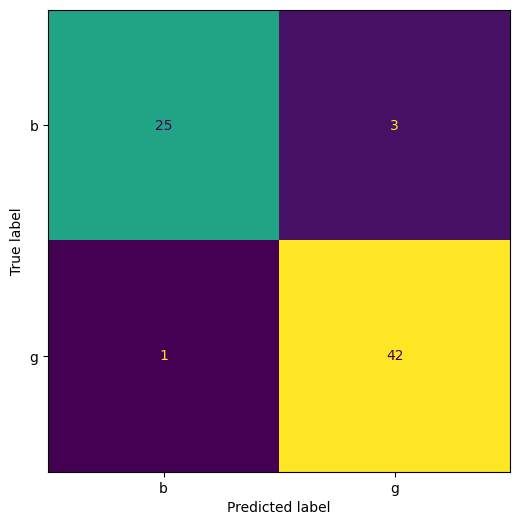

In [59]:
n_estimators_need = np.arange(50, 250, 50)
criterion_need = ["gini", "entropy", "log_loss"]
max_depth_need = np.arange(5, 15)
min_samples_split_need = np.arange(2, 4)

model_RF = RF()
params = {
    "n_estimators" : n_estimators_need, 
    "criterion" : criterion_need, 
    "max_depth" : max_depth_need, 
    "min_samples_split" : min_samples_split_need
}
grid_search = GridSearchCV(estimator = model_RF, param_grid = params)
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
knn_preds = grid_search.predict(x_test)
compare_quality(knn_preds, np.array(y_test))

In [82]:
print(grid_search.best_score_)
print(grid_search.best_params_)
rf_preds = grid_search.predict(x_test)

0.9464285714285715
{'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 50}


              precision    recall  f1-score   support

           b       0.96      0.89      0.93        28
           g       0.93      0.98      0.95        43

    accuracy                           0.94        71
   macro avg       0.95      0.93      0.94        71
weighted avg       0.94      0.94      0.94        71



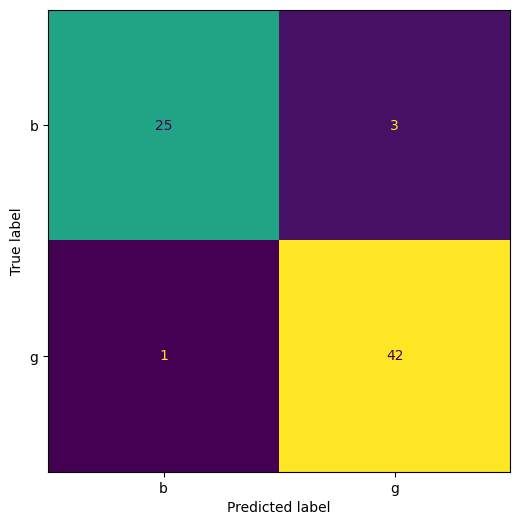

In [84]:
compare_quality(rf_preds, np.array(y_test))

In [86]:
print(grid_search.best_score_)
print(grid_search.best_params_)
rf_preds = grid_search.predict(x_train)

0.9464285714285715
{'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 50}


              precision    recall  f1-score   support

           b       1.00      1.00      1.00        98
           g       1.00      1.00      1.00       182

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



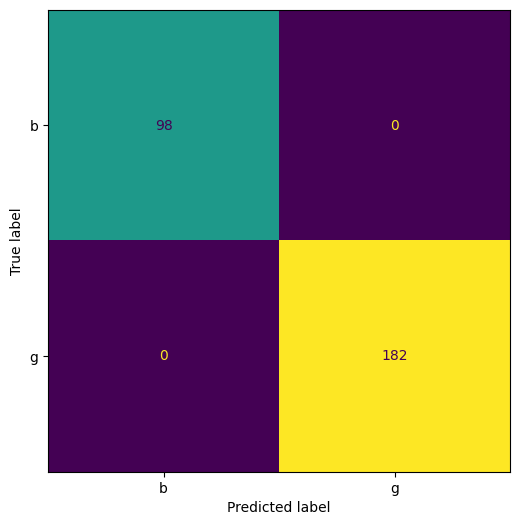

In [87]:
compare_quality(rf_preds, np.array(y_train))

#### TSNE

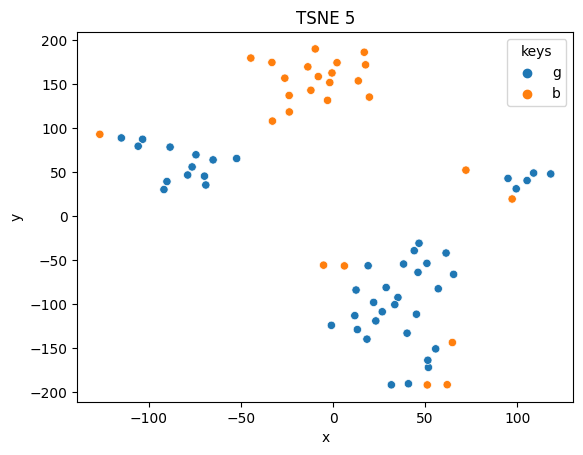

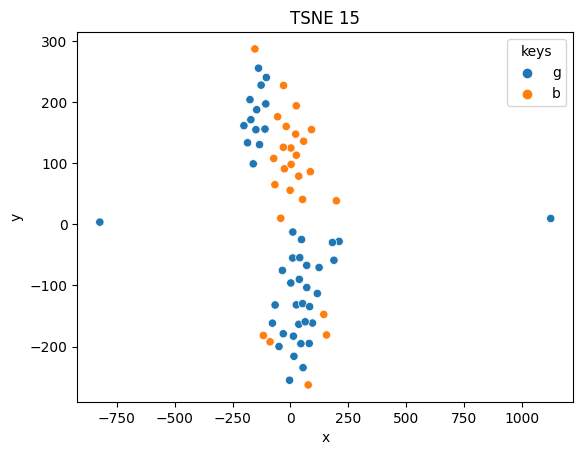

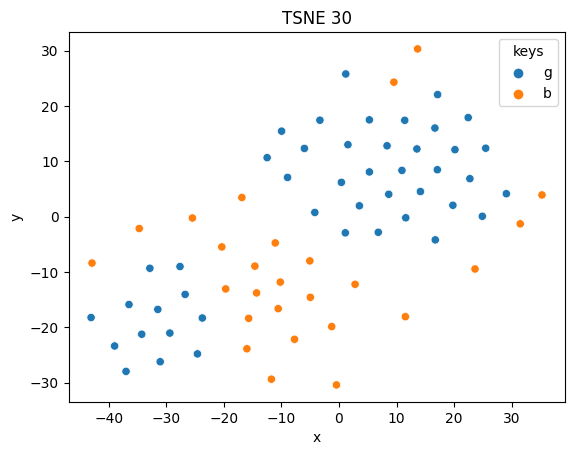

In [75]:
tsne_minmax_plots = make_tsne(x_test, rf_preds, perplexities=[5, 15, 30])

#### UMAP

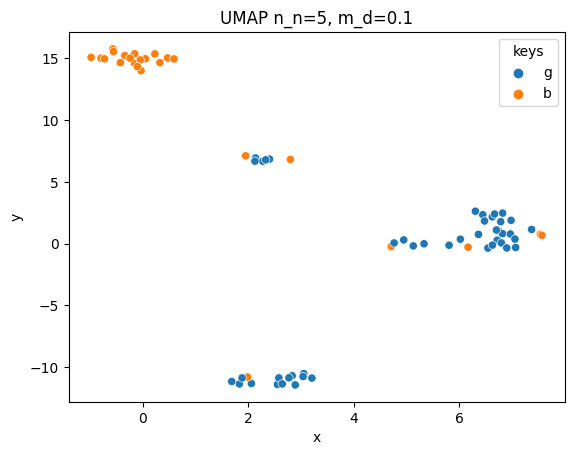

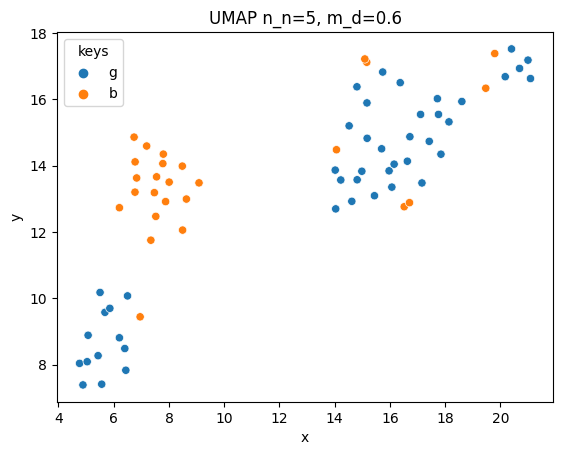

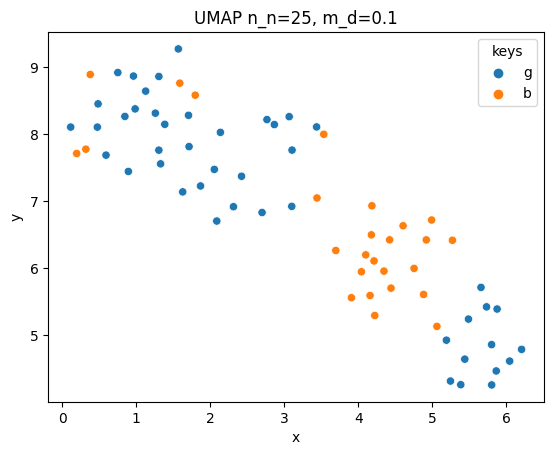

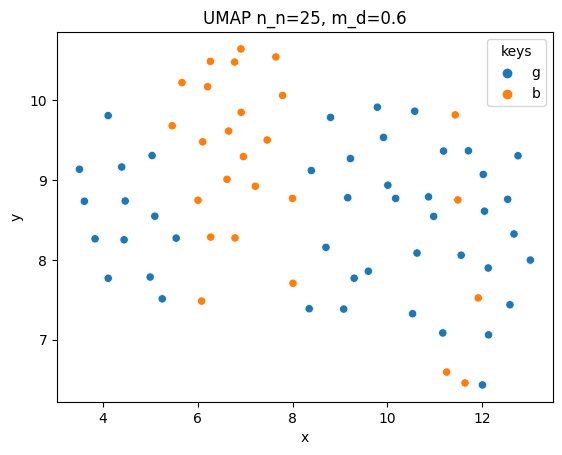

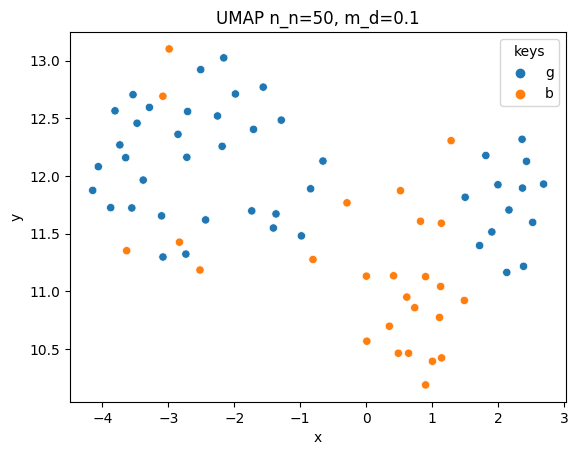

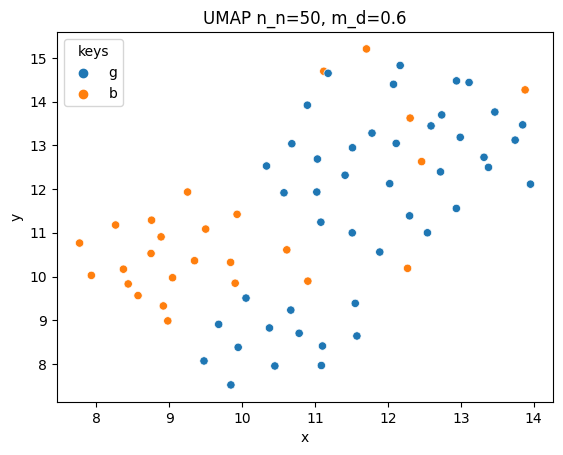

In [76]:
n_n = (5, 25, 50)
m_d = (0.1, 0.6)

um = make_umap(x_test, rf_preds, n_n, m_d)
umap_plots_minmax = plot_umap(um, n_n, m_d)

#### Отрисовка

In [65]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_split=2)
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

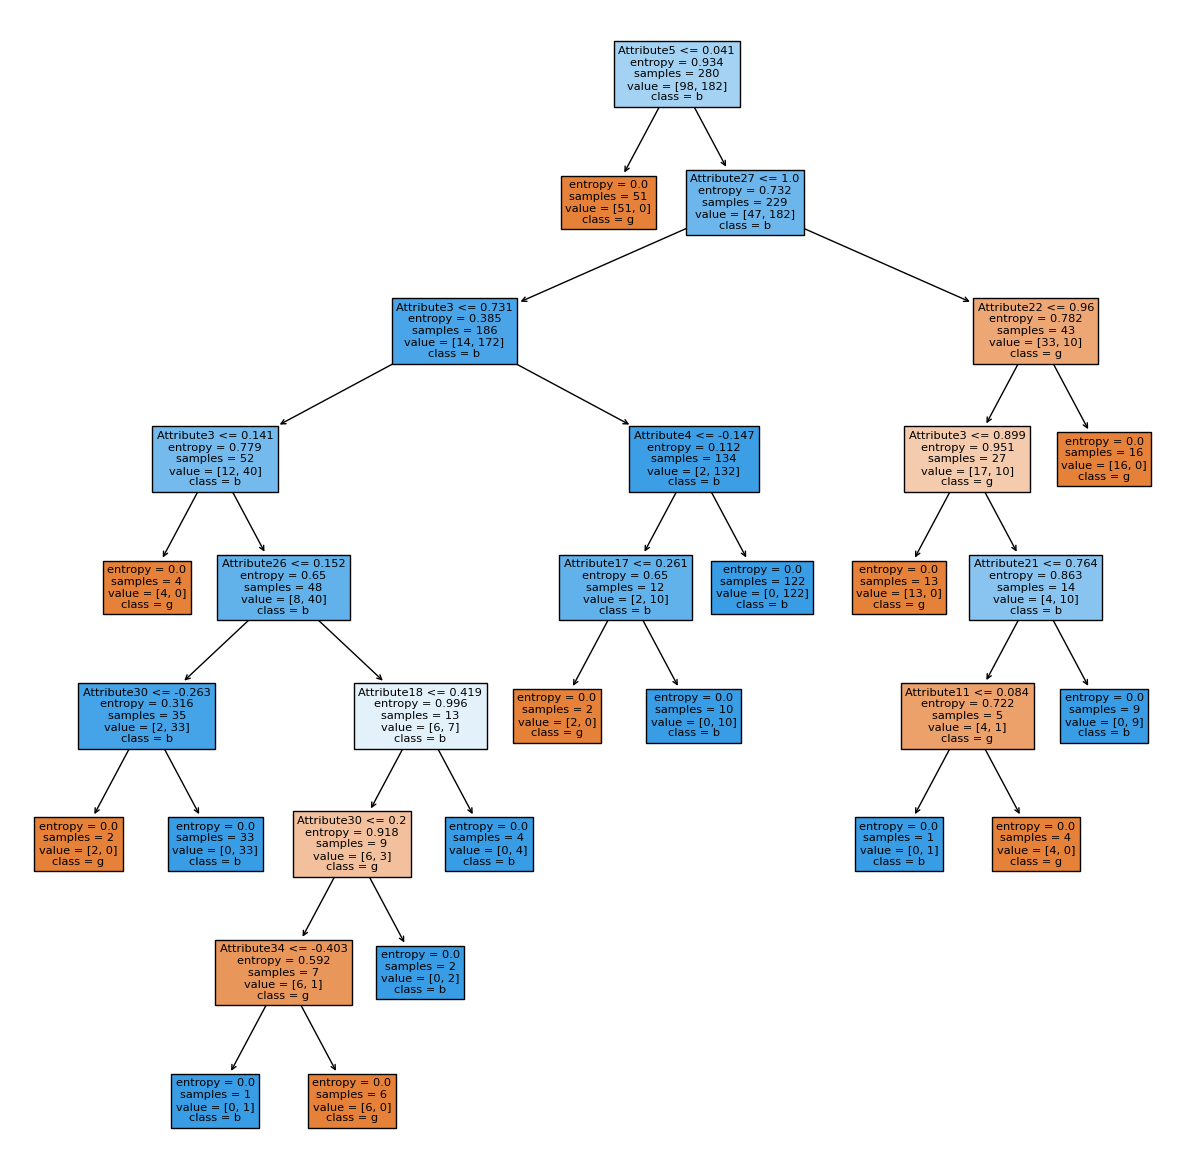

In [70]:
fig = plt.figure(figsize=(15,15))
tree.plot_tree(model,
               feature_names=X.columns.values,
               class_names=["g", "b"],
               filled=True)
fig.savefig("./images/RD/decision_tree.png", dpi=500)